

## Seasonality

In [1]:
#pip install pytsdatasets

https://github.com/mjuez/pytsdatasets

@software{pytsdatasets,
  author       = {Mario Juez-Gil},
  title        = {{mjuez/pytsdatasets}},
  month        = oct,
  year         = 2020,
  publisher    = {Zenodo},
  version      = {v1.0},
  doi          = {10.5281/zenodo.4063496},
  url          = {https://doi.org/10.5281/zenodo.4063496}
}

In [2]:
#import pytsdatasets as tsds
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

Seasonality in times series is a periodic pattern present in the series, that can have different periodicity and can be superimposed to a trend. We will analyze the dataset "Air Passengers" which is the original dataset proposed by Box and Jenkins of 1976 (http://calcnet.mth.cmich.edu/org/spss/prj_airlinepassengers.htm)

### Air Passengers datasets
The classic Box & Jenkins airline data. Monthly totals of international airline passengers, 1949 to 1960.

In [3]:
data2 = pd.read_csv('air_passangers.csv')
data2.reset_index(inplace=True)
data2['date']=data2['date'].astype('str')

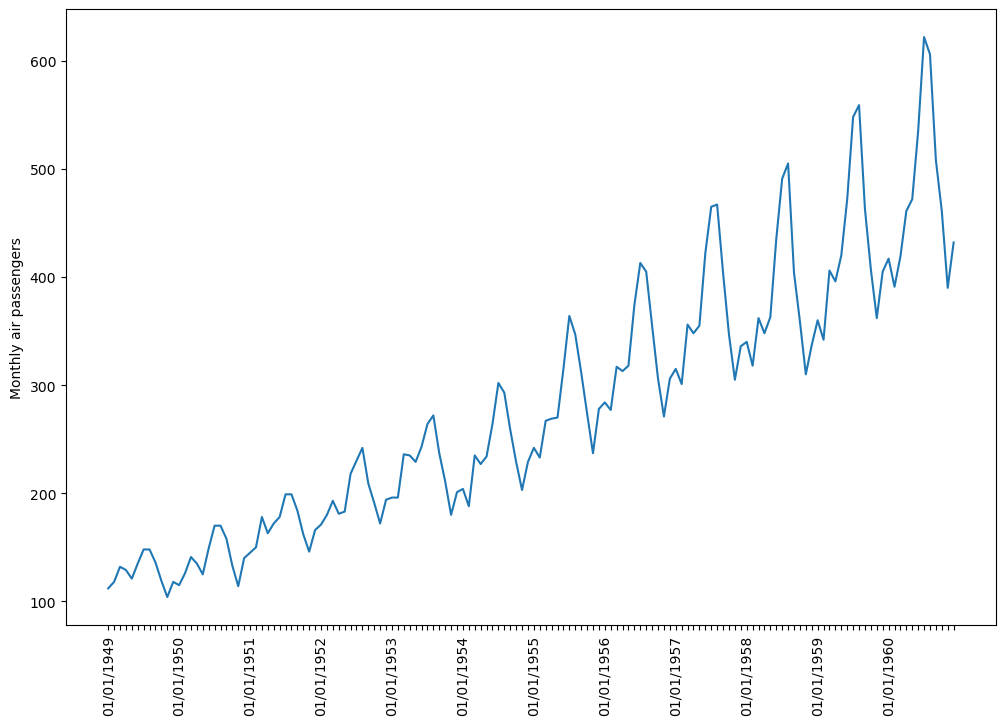

In [4]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(data2['date'],data2['data'])
plt.xticks(rotation = 90,size=10)
plt.ylabel('Monthly air passengers')
every_nth = 12
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.show()

We can clearly observe that there is a yearly seasonality, i.e. a similar pattern repeats year by year, but we can also see that within each year there are other periodic fluctuations. Sometimes, it is not clear from the plot to detect the periodicity of the seasonality. We can build a "periodogram" to detect the strongest frequencies from the "signal" (i.e. the series) and thus calculate the periods of seasonalities. We first have to remove the trend from the series.

https://milos.ai/2018/05/extracting-frequencies-from-time-series-python


### Removing trend

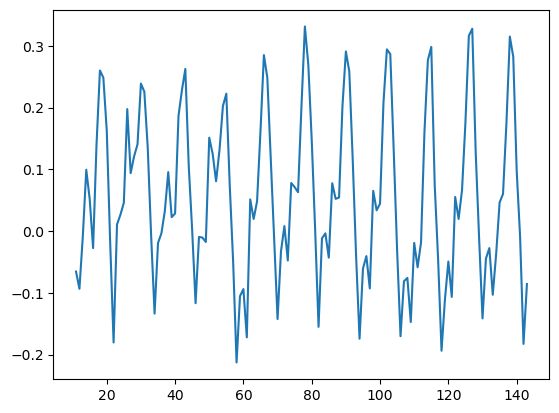

In [5]:
tslog = np.log(data2['data'])
rollavg = tslog.rolling(12).mean()
tslogdiff = tslog - rollavg
tslogdiff.dropna(inplace = True)
plt.plot(tslogdiff)
plt.show()

### Periodogram

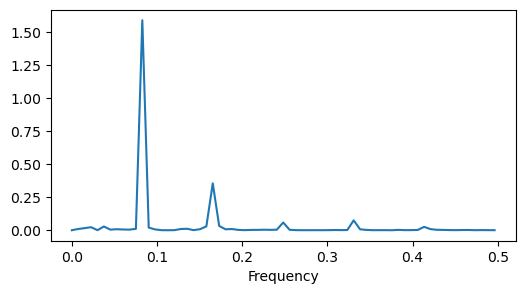

In [6]:
from scipy import signal
f, Pxx = signal.periodogram(tslogdiff)
fig, ax = plt.subplots(figsize=(6,3))
plt.plot(f, Pxx)
plt.xlabel('Frequency')
plt.show()


We can observe that there are two strongest components, at frequencies very close to 0.1 and close to 0.2.

In [7]:
top_4_periods = {}

# get indices for 4 highest Pxx values
top4_freq_indices = np.flip(np.argsort(Pxx), 0)[0:4]


freqs = f[top4_freq_indices]

# use same indices to get powers as well
power = Pxx[top4_freq_indices]

# we are interested in period and it is calculated as 1/frequency
periods = 1 / np.array(freqs)

# populate dict with calculated values
top_4_periods['period1'] = periods[0]
top_4_periods['freq1'] = freqs[0]
top_4_periods['power1'] = power[0]

top_4_periods['period2'] = periods[1]
top_4_periods['freq2'] = freqs[1]
top_4_periods['power2'] = power[1]

top_4_periods['period3'] = periods[2]
top_4_periods['freq3'] = freqs[2]
top_4_periods['power3'] = power[2]

top_4_periods['period4'] = periods[3]
top_4_periods['freq4'] = freqs[3]
top_4_periods['power4'] = power[3]


In [8]:
top_4_periods


{'period1': 12.090909090909092,
 'freq1': 0.08270676691729323,
 'power1': 1.5872570162369508,
 'period2': 6.045454545454546,
 'freq2': 0.16541353383458646,
 'power2': 0.3541930224044221,
 'period3': 3.022727272727273,
 'freq3': 0.3308270676691729,
 'power3': 0.07463805391631227,
 'period4': 4.03030303030303,
 'freq4': 0.24812030075187969,
 'power4': 0.058300601806708166}

The first strong frequency corresponds to a period of 12 months (the data represents air passengers each month), i.e. a yearly seasonal component. The second strong frequency corresponds to a period of 6 months. We can visualize this information plotting the periodogram using period and not frequency:

In [9]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    freqencies, spectrum = periodogram(ts)
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1/12, 1/6, 1/4, 1/3, 1/2])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "3 months",
            "Bimonthly (6)",


        ],
        rotation=90,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


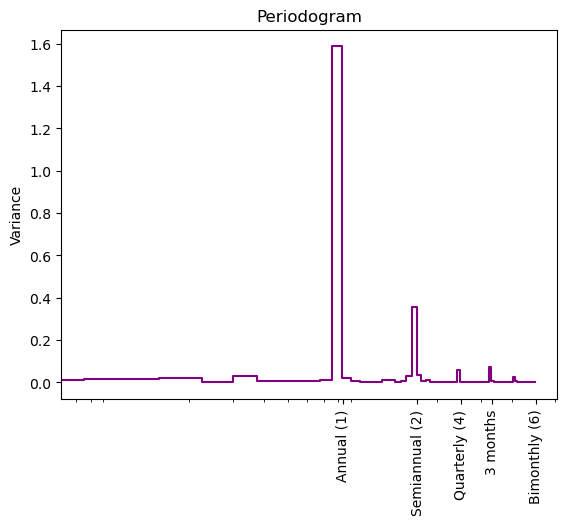

In [10]:
plot_periodogram(tslogdiff)
plt.show()

## Decomposition

We can think the observed series as the result of three components: trend, seasonality and white noise. We have learned, for example, how to decompose and remove the trend by differencing or calculating the moving average across all the series and removing it.
When we use decomposition, we may select two kinds of models, additive and multiplicative model:

* Additive model : series = trend+seasonality+noise

* Multiplicative model: series = trend x seasonality x noise

When we observe from the time series plot that the trend and the oscillations due to seasonality stay relatively constant we may think to an additive model, otherwise we use a multiplicative model. For the "Air Passengers" data, the trend is almost linear, but the amplitude of the oscillations are increasing with time, so we will apply a multiplicative model.


In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(data2['data'], model='multiplicable',period=12)

<Axes: >

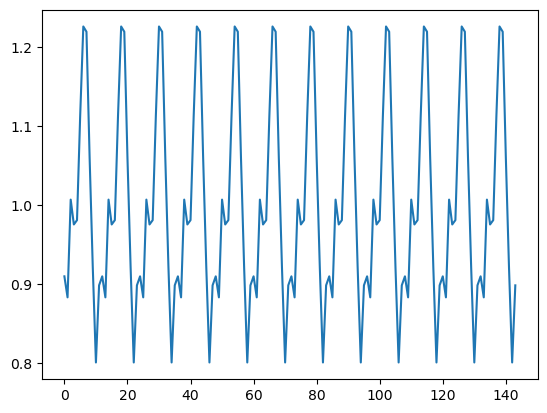

In [12]:
result.seasonal.plot()

<Axes: >

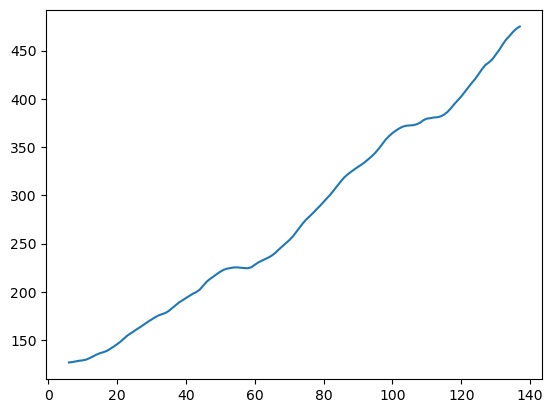

In [13]:
result.trend.plot()


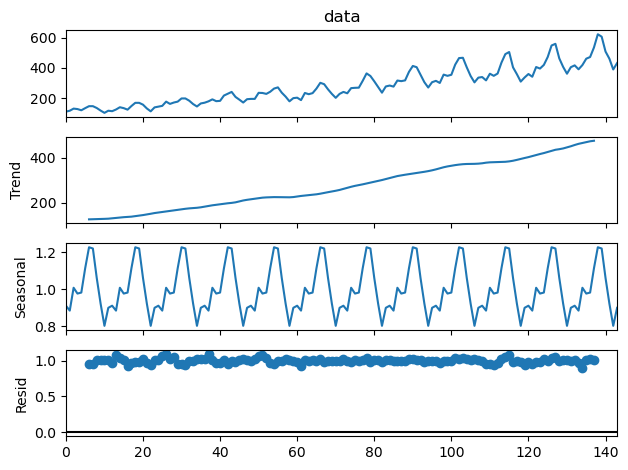

In [14]:
result.plot()
plt.show()

The decomposition has the drawback that introduces N/A in the first observations due to the calculation od moving averages. Also, the decomposition is slow to catch sudden changes and it can be applied only to series with a constant seasonality.